## Import libraries

In [ ]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from xgboost import XGBClassifier

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

## Getting the Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df = pd.concat([train , test])

In [3]:
df.head(10)

,Label,Word
0,1.0,Аалтонен
1,0.0,Аар
2,0.0,Аарон
3,0.0,ААРОН
4,0.0,Аарона
5,1.0,Аарона
6,0.0,Аароне
7,0.0,Ааронов
8,0.0,Аахена
9,1.0,Абабков


## New Features Generation

### Capital letter

In [4]:
def is_first_upper(string):
    return string[0].istitle()

In [5]:
df['first_upper'] = df['Word'].apply(lambda x: is_first_upper(x)).astype(int)

### Characters except letters

In [6]:
letters = [chr(ord('а') + i) for i in range(32)]
letters.append('ё')

In [7]:
letters.extend([x.upper() for x in letters])

In [8]:
print(letters)

['а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'Ё']


In [9]:
def hasOthersSymbols(string):
    for c in string:
        if c not in letters:
            return 1
    return 0

In [10]:
df['other_symbols'] = df['Word'].apply(lambda x: hasOthersSymbols(x))

### Dash

In [11]:
def hasDash(string):
    for c in string:
        if (c == '-'):
            return 1
    return 0

In [12]:
df['dash'] = df['Word'].apply(lambda x: hasDash(x))

### Second apostrophe

In [13]:
def hasSecondApostrophe(string):
    if (len(string) < 2):
        return 0
    if (string[1] == "’" or string[1] == "'"):
        return 1
    else: 
        return 0

In [14]:
df['apostrophe'] = df['Word'].apply(lambda x: hasSecondApostrophe(x))

### Length

In [15]:
df['len'] = df['Word'].apply(lambda x: len(x))

### Length distribution

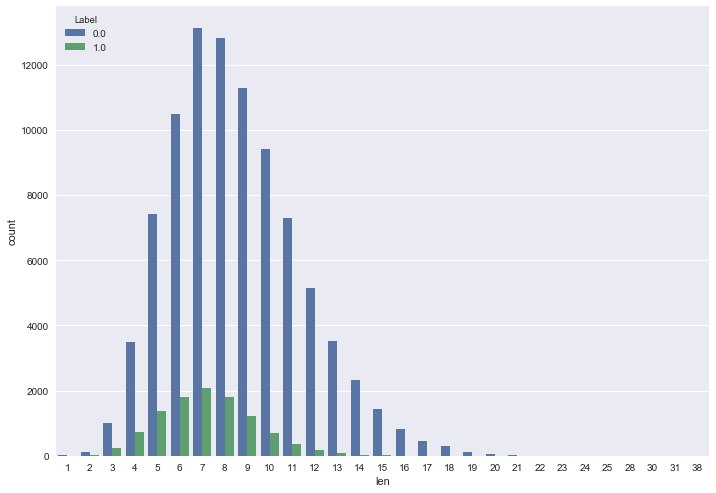

In [16]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(x='len', hue='Label', data=df)

In [17]:
df[df['Label'] == 1]['len'].value_counts()

7     2078
6     1816
8     1801
5     1377
9     1209
4      728
10     696
11     362
3      234
12     168
13      77
2       37
14      31
15      14
17       5
18       2
1        2
16       1
Name: len, dtype: int64

In [18]:
df['len_more_14'] = (df['len'] > 14).astype(int)

### TF-IDF

In [19]:
bigram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(1,10), max_features = 100, encoding='utf8')

for_tf_idf = bigram_vectorizer.fit_transform(df['Word'].apply(lambda x :x.lower()).tolist())

tfidf_sparse = TfidfTransformer().fit_transform(for_tf_idf)

In [20]:
tfidf = pd.DataFrame(tfidf_sparse.toarray() , index=df.index, \
                     columns=['tf_idf_' + str(i) for i in range(tfidf_sparse.shape[1])])

In [21]:
df = pd.concat([df, tfidf], axis=1)

In [22]:
df.head()

,Label,Word,first_upper,other_symbols,dash,apostrophe,len,len_more_14,tf_idf_0,tf_idf_1,...,tf_idf_90,tf_idf_91,tf_idf_92,tf_idf_93,tf_idf_94,tf_idf_95,tf_idf_96,tf_idf_97,tf_idf_98,tf_idf_99
0,1.0,Аалтонен,1,0,0,0,8,0,0.177088,0.368749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,Аар,1,0,0,0,3,0,0.287276,0.598193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,Аарон,1,0,0,0,5,0,0.224643,0.467774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,ААРОН,1,0,0,0,5,0,0.224643,0.467774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,Аарона,1,0,0,0,6,0,0.186412,0.388164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train

In [23]:
df_train = df.iloc[train.index]

In [24]:
df_test = df.iloc[df_train.shape[0]:]

In [25]:
df_test.drop(['Label'], axis=1, inplace=True)

D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['Word', 'Label'], axis=1), df_train.drop(['Word'], axis=1)['Label'], test_size=0.2, random_state=42)

In [27]:
model = XGBClassifier(max_depth=12, n_estimators=700 , learning_rate=0.05)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=700,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [28]:
preds = model.predict(X_test)

D:\Programs\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [29]:
print(classification_report(preds, y_test))

             precision    recall  f1-score   support

        0.0       0.98      0.93      0.95     19161
        1.0       0.36      0.70      0.48      1121

avg / total       0.95      0.92      0.93     20282



## Test

In [31]:
sample = pd.read_csv('sample_submission.csv')
sample['Prediction'] = model.predict_proba(df_test.drop(['Word'], axis=1))
sample.to_csv('submit.csv' , index=False)